<a href="https://colab.research.google.com/github/jirikadlec2/cloud_computing_workshop/blob/main/notebooks/lake_chad_water1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Install the required packages if they are not already present
! pip install pystac_client odc-stac matplotlib pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 623.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 46.4 MB/s eta 0:00:00


In [7]:
# Importing the dependencies

from pystac_client import Client
from odc.stac import configure_rio, stac_load

Configure the bands

In [8]:
config = {
    "s2_l2a": {
        "assets": {
            "*": {
                "data_type": "uint16"
            }
        },
        "aliases": {
            "costal_aerosol": "B01",
            "blue": "B02",
            "green": "B03",
            "red": "B04",
            "red_edge_1": "B05",
            "red_edge_2": "B06",
            "red_edge_3": "B07",
            "nir": "B08",
            "nir_narrow": "B08A",
            "water_vapour": "B09",
            "swir_1": "B11",
            "swir_2": "B12",
            "mask": "SCL",
            "aerosol_optical_thickness": "AOT",
            "scene_average_water_vapour": "WVP",
        },
    }
}

In [9]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

In [10]:
# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

In [11]:
# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
#bbox = [13.5, 13.7, 13.7, 13.9]
bbox = [13.1, 12.5, 15.1, 14.5]

# Set a start and end date
start_date = "2019-01-01"
end_date = "2025-07-01"

# Set the STAC collections
collections = ["gm_s2_rolling"]

In [12]:
# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 924 datasets


In [ ]:
crs = "EPSG:6933"
resolution = 500

ds = stac_load(
    items,
    bands=("B03","B11",),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox,
)

# View the Xarray Dataset
ds

<xarray.Dataset> Size: 163MB
Dimensions:      (y: 1243, x: 966, time: 17)
Coordinates:
  * y            (y) float64 10kB 1.831e+06 1.83e+06 ... 1.582e+06 1.582e+06
  * x            (x) float64 8kB 1.264e+06 1.264e+06 ... 1.457e+06 1.457e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 136B 2024-01-01 2024-02-01 ... 2025-05-01
Data variables:
    B03          (time, y, x) float32 82MB dask.array<chunksize=(1, 1243, 966), meta=np.ndarray>
    B11          (time, y, x) float32 82MB dask.array<chunksize=(1, 1243, 966), meta=np.ndarray>

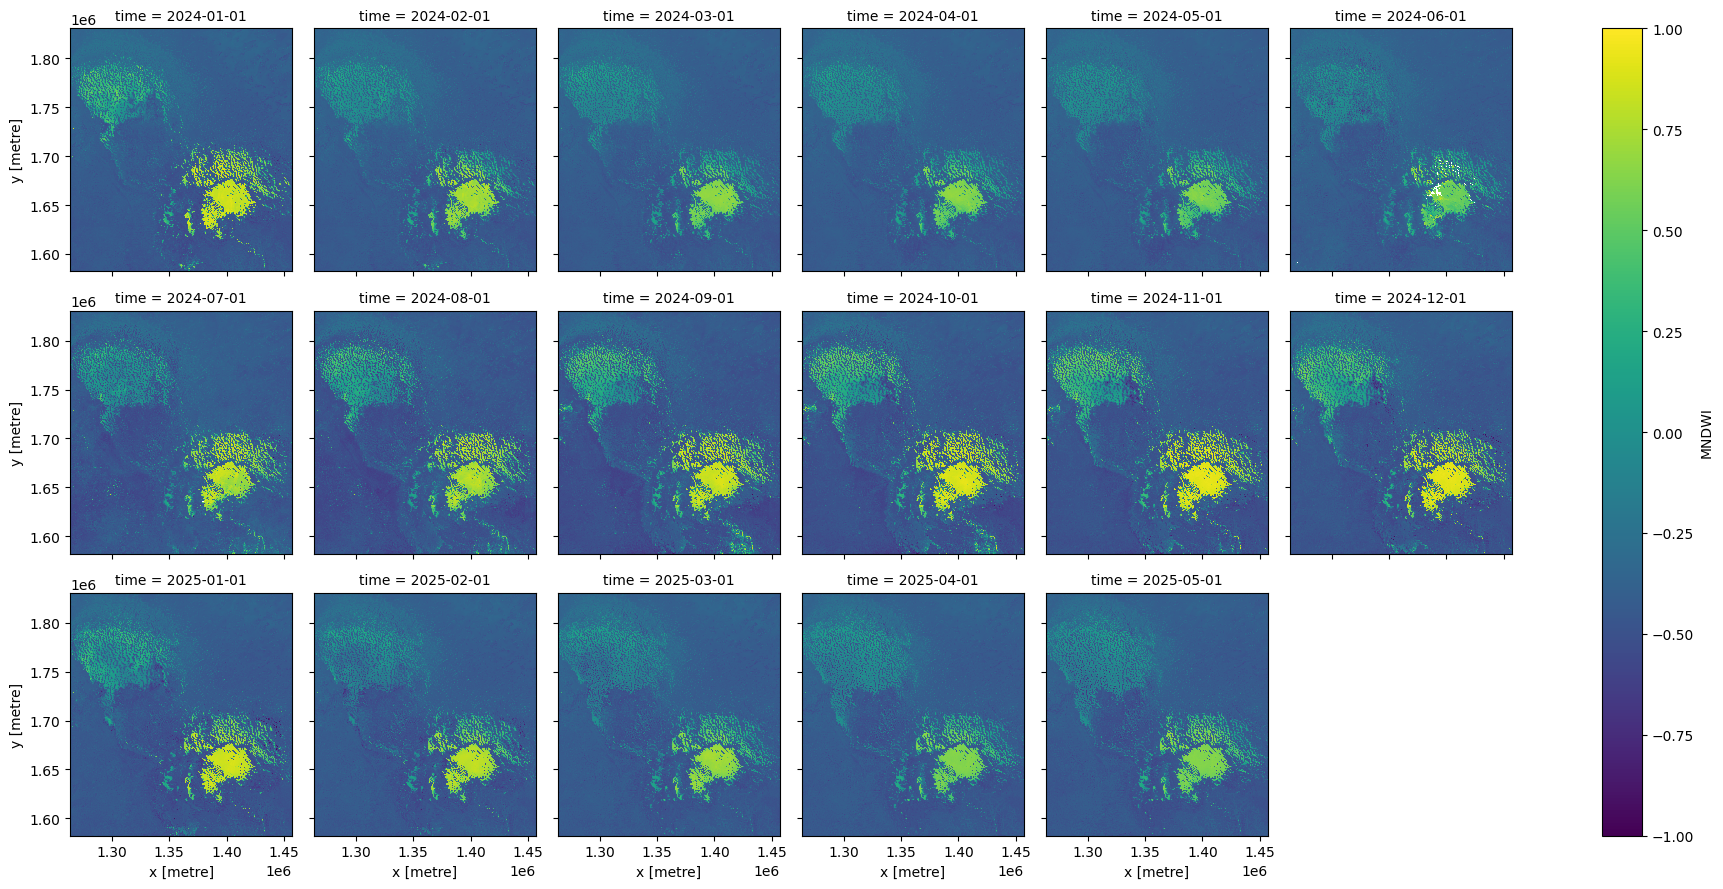

In [ ]:
ds["MNDWI"] = (ds.B03 - ds.B11) / (ds.B03 + ds.B11)


ds.MNDWI.compute().plot(col="time", col_wrap=6, vmin=-1, vmax=1)